# CME538 - Introduction to Data Science
## Lecture 6.3 - Gradient Descent II

## Setup Notebook

In [8]:
# Import 3rd party libraries
import random
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import cm
import matplotlib.pylab as plt
from ipywidgets import interact, fixed, IntSlider

# Configure Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

# Import Tips Data
Let's import out tips dataset from `Seaborn`.

In [9]:
tips = sns.load_dataset('tips')
tips = tips.iloc[0:-1]
tips.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Add a column representing the tip percentage.

In [10]:
tips['tip_pct'] = tips['tip'] / tips['total_bill'] * 100
tips.head()

,total_bill,tip,sex,smoker,day,time,size,tip_pct
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


Text(0.5, 0, 'Tip Percentage')

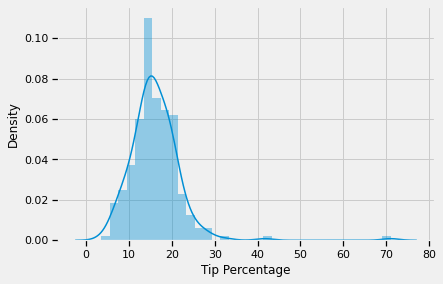

In [11]:
ax = sns.distplot(tips['tip_pct'])
ax.set_xlabel('Tip Percentage')

# Stochastic Gradient Descent

In [12]:
def mse(theta0, theta1, x, y_obs):
    y_hat = theta0 + theta1 * x
    return np.mean((y_hat - y_obs) ** 2)

def grad_mse(theta0, theta1, x, y_obs):
    y_hat = theta0 + theta1 * x
    grad_0 = -2 * (y_obs - y_hat)
    grad_1 = -2 * x * (y_obs - y_hat)
    return grad_0, grad_1

In [13]:
def minimize_sgd(steps, epochs, data_ids, loss_fn, grad_loss_fn, 
                 x, y_obs, alpha=0.2):
    """
    Uses gradient descent to minimize loss_fn. Returns the minimizing value of
    theta once theta changes less than 0.001 between iterations.
    """
    # Scale features
    x = (x - np.mean(x)) / np.std(x)
    y_obs = (y_obs - np.mean(y_obs)) / np.std(y_obs)
    
    # Convert steps
    steps = range(steps)
    
    # Set starting epoch
    epochs_conv = []
    
    # Set loss array
    losses = []
    losses_conv = []
    
    # Set theta array
    theta0s = []
    theta1s = []
    
    # Setup figure
    fig = plt.figure(figsize=(14, 12))
    fig.subplots_adjust(wspace=0.2, hspace=0.2)
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax3 = plt.subplot2grid((2, 2), (1, 0))
    ax4 = plt.subplot2grid((2, 2), (1, 1), projection='3d')
    
    # Plot total_bill vs tip
    sns.scatterplot(x, y_obs, ax=ax1)
    ax1.xaxis.set_tick_params(labelsize=14)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_ylabel('Tip', fontsize=18)
    ax1.set_xlabel('Total Bill', fontsize=18)
    ax1.set_xlim([-2, 4])
    ax1.set_ylim([-2, 6])
    
    # Plot 2D contour
    theta0_grid = np.linspace(-10, 15, 200)
    theta1_grid = np.linspace(-10, 10, 200)
    loss_grid = np.zeros([len(theta1_grid), len(theta0_grid)])
    for theta0_id, theta0 in enumerate(theta0_grid):
        for theta1_id, theta1 in enumerate(theta1_grid):
            loss_grid[theta1_id, theta0_id] = loss_fn(theta0, theta1, x, y_obs)
    X, Y = np.meshgrid(theta0_grid, theta1_grid)
    cp = ax3.contour(X, Y, loss_grid, 6, colors='white', linestyles='dashed', linewidths=1)
    ax3.clabel(cp, inline=1, fmt='%1.1f', fontsize=15 )
    ax3.contourf(X, Y, loss_grid, alpha=0.65,cmap=cm.viridis) 
    ax3.set_xlabel('$\\theta_0$', fontsize=18)
    ax3.set_ylabel('$\\theta_1$', fontsize=18)

    # 3D Surface
    surf = ax4.plot_surface(X, Y, loss_grid, cmap='viridis', rstride=1, cstride=1, antialiased=True, alpha=0.65)
    ax4.set_xlabel('$\\theta_0$', fontsize=18)
    ax4.set_ylabel('$\\theta_1$', fontsize=18)
    ax4.set_zlabel('Loss', fontsize=18, rotation=90)
    
    # Set starting theta
    theta0 = 12.5
    theta1 = 7.5

    for step in steps:
    
        # Update losses
        losses.append(loss_fn(theta0, theta1, 
                              x[data_ids[step]], 
                              y_obs[data_ids[step]]))

        # Update thetas
        theta0s.append(theta0)
        theta1s.append(theta1)

        # Compute gradient
        gradient_0, gradient_1 = grad_loss_fn(theta0, 
                                              theta1, 
                                              x[data_ids[step]], 
                                              y_obs[data_ids[step]])

        # Get new theta
        new_theta0 = theta0 - alpha * gradient_0
        new_theta1 = theta1 - alpha * gradient_1

        # Update theta
        theta0 = new_theta0
        theta1 = new_theta1

    # Check for convergence
    ax2.plot(np.array(list(steps)) / len(x), losses, '-o', markeredgecolor='k', ms=10)
    ax2.set_xlim([-0.1, 1])
    ax2.set_ylim([-20, 220])
    ax2.set_xlabel('Epoch', fontsize=18)
    ax2.set_ylabel('Loss', fontsize=18)
    ax2.xaxis.set_tick_params(labelsize=14)
    ax2.yaxis.set_tick_params(labelsize=14)
    
    # Plot updated model
    ax1.set_title('$\\theta_0$ = {}\n$\\theta_1$ = {}'.format(np.round(theta0, 2), np.round(theta1, 2)), fontsize=18)
    ax1.plot(x, theta0 + x*theta1, linestyle='-', lw=3, color='#fc4f30')
    
    # Add updated" theta 
    ax3.plot(theta0s, theta1s, '-', lw=4)
    ax3.plot(theta0s[-1], theta1s[-1], 'o', markeredgecolor='k', ms=10)
    
    # Add updated theta
    ax4.plot(theta0s, theta1s, losses, '-', lw=4)
    ax4.plot(theta0s[-1], theta1s[-1], losses[-1], 'o', markeredgecolor='k', ms=10)
    
    plt.show()

In [14]:
alpha = 0.02
num_epochs = 20
num_obs = len(tips)
num_steps = num_epochs * num_obs 
data_ids = list()
for _ in range(num_epochs):
    temp = list(range(num_obs))
    random.shuffle(temp)
    data_ids.extend(temp)
epochs = [i for i in range(num_steps) for _ in range(num_epochs)]

# Launch widget
interact(minimize_sgd,
         steps=IntSlider(value=1, min=1, max=num_steps, step=1),
         epochs=fixed(epochs),
         data_ids=fixed(data_ids),
         loss_fn=fixed(mse),
         grad_loss_fn=fixed(grad_mse),
         x=fixed(tips['total_bill'].values),
         y_obs=fixed(tips['tip'].values),
         alpha=fixed(alpha));

interactive(children=(IntSlider(value=1, description='steps', max=4860, min=1), Output()), _dom_classes=('widg…